# < 다음에 볼 영화 예측하기 >

**- 목차 -**

□ Step1 데이터 로드 및 전처리   
□ Step2 미니 배치 구성   
□ Step3 모델 구성   
□ Step4 모델 학습    
□ Step5 모델 테스트   
□ Step6 모델 성능 개선   
□ 정리 및 회고

### ■ Step1 데이터 로드 및 전처리

**1-1 필요한 라이브러리 import**

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

**1-2 데이터 불러오기**

In [23]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


**1-3 데이터 정보 확인**

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


**1-4 시간을 표준시로 변경**

In [25]:
data['Time']=pd.to_datetime(data['Time'],unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


**1-5 유저 수, 영화 수, 시간 수 확인**

In [26]:
print('Unique 유저 수 :', data['UserId'].nunique())
print('Unique 영화의 수', data['ItemId'].nunique())
print('Unique 시간의 수', data['Time'].nunique())

Unique 유저 수 : 6040
Unique 영화의 수 3706
Unique 시간의 수 458455


**1-6 UserID와 Time을 기준으로 데이터프레임 생성**

In [27]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
...,...,...,...,...
471158,471158,6040,2001-08-10 14:39:58,1
471159,471159,6040,2001-08-10 14:40:29,1
471160,471160,6040,2001-08-10 14:41:04,2
471161,471161,6040,2001-08-10 14:41:26,1


**1-7 SessionID 컬럼 추가**

In [28]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


**1-8 Session 길이 확인**

In [29]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

**1-9 Session 길이 세부 정보 확인**

In [30]:
print('session_median :', session_length.median())
print('session_mean :', session_length.mean())
print('session_min :', session_length.min())
print('session_max :', session_length.max())
print('99.9% 분위수 :', session_length.quantile(0.999))

session_median : 2.0
session_mean : 2.1228513274599234
session_min : 1
session_max : 30
99.9% 분위수 : 10.0


**1-10 Session 길이 분포 누적합 확인**

In [31]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

- 세션 길이에 따라 세션을 분류했을때 얼마만큼의 세션이 포함되는지를 나타냄
- 9이하의 세션 길이를 가진 세션이 전체의 99.7%

**1-11 Session 길이 분포 누적합 시각화**

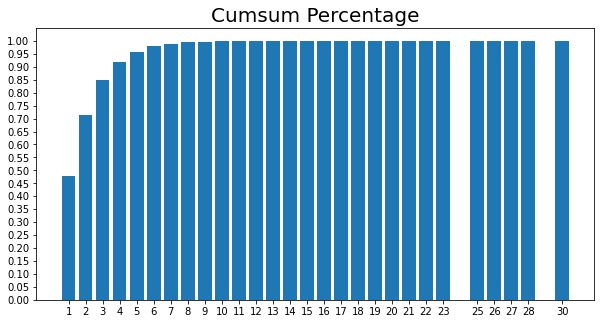

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum)
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

- 대부분의 데이터들은 세션 길이가 9이하

**1-12 Session 길이가 30인 데이터 확인 및 제거**

In [33]:
long_session = session_length[session_length==30].index[0]
display(data[data['SessionId']==long_session])
data[data['SessionId']==long_session].shape

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,2000-11-29 20:06:42,55117
112348,731,1455,3,2000-11-29 20:06:42,55117
112349,731,1639,5,2000-11-29 20:06:42,55117
112350,731,3244,4,2000-11-29 20:06:42,55117
112351,731,1656,2,2000-11-29 20:06:42,55117
112352,731,3426,4,2000-11-29 20:06:42,55117
112353,731,1829,2,2000-11-29 20:06:42,55117
112354,731,2675,4,2000-11-29 20:06:42,55117
112355,731,802,3,2000-11-29 20:06:42,55117
112356,731,803,5,2000-11-29 20:06:42,55117


(30, 5)

In [34]:
# 1초만에 30개의 영화를 평가했으므로 이상치로 판단하여 제거

data = data.loc[data['SessionId'] != long_session]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


**1-13 데이터가 발생한 가장 오래된 시간과 가장 최근 시간 확인**

In [35]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 가장 오래된 시간과 가장 최근 시간을 확인해 보니, 약 3년 정도 시간의 데이터가 있음

**1-14 평점 3점 이상의 선호하는 영화만 남기고 제거**

In [37]:
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


**1-15 데이터 분리 함수 정의**

In [39]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

**1-16 최근 3개월 까지의 데이터를 test set으로 분리**

In [40]:
tr, test = split_by_date(data, n_days = 100)

**1-17 train set 중 최근 1년 까지의 데이터를 validation set으로 분리**

In [41]:
tr, val = split_by_date(tr, n_days = 365)

**1-18 데이터 정보 확인 함수 정의**

In [42]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

**1-19 데이터 정보 확인**

In [43]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 810327
	 Sessions: 404871
	 Items: 3612
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-11-20 05:13:09

* valid Set Stats Info
	 Events: 21991
	 Sessions: 15450
	 Items: 2820
	 First Time : 2001-11-20 19:04:49
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 4118
	 Sessions: 3071
	 Items: 1625
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



**1-20 train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱**

In [44]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  #id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

**1-21 데이터 저장 및 pipline 구축**

In [45]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### ■ Step2 미니 배치 구성

**2-1 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스 생성**

In [47]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

**2-2 train데이터로 SessionDataset 객체 만들기**

In [48]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


**2-3 각 세션이 시작된 인덱스 확인**

In [49]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 810325, 810326, 810327], dtype=int32)

**2-4 각 섹션을 인덱싱한 `np.array` 확인**

In [50]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 404868, 404869, 404870])

**2-5 SessionDataset 객체를 받아 Session-Parallel mini-batch를 만드는 클래스 생성**

In [51]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        #첫 배치에 사용할 세션 Index
        first_iters = np.arange(self.batch_size)
        
        #마지막으로 다루고 있는 세션 Index
        last_session = self.batch_size - 1    
        
        #data 상에서 session이 시작된 위치
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]   
        
        #session이 끝난 위치 바로 다음 위치
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  
        
        #session의 모든 아이템을 다 돈 경우 mask에 추가
        mask = np.array([])
        
        #data를 전부 돌았는지 기록하기 위한 변수.        
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        #다음 배치 데이터를 생성하기 위해 상태를 update.
        
        #__iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌.
        start += min_len   
        
        #mask에 기록.
        #end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻. 
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        

        for i, idx in enumerate(mask, start=1):  #mask에 추가된 세션 개수만큼 새로운 세션을 반복.
            new_session = last_session + i 
            
            #새로운 세션이 마지막 세션 index보다 크면 모든 학습데이터를 다 돈 것.
            if new_session > self.dataset.session_idx[-1]:  
                finished = True
                break

            # update the next starting/ending point
            #종료된 세션 대신 새로운 세션의 시작점 기록
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  #마지막 세션의 위치 기록
        return start, end, mask, last_session, finished

**2-6 미니 배치 만들기**

In [52]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [53]:
iter_ex = iter(tr_data_loader)

In [54]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


### ■ Step3 모델 구성

**3-1 Evaluation Metric 함수 정의**

In [55]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

**3-2 모델 설계를 위해 필요한 라이브러리 import**

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

**3-3 모델 설계 함수 정의**

In [57]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

**3-4 모델 hyper-parameter를 관리할 class 생성**

In [58]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

**3-5 모델 설계**

In [71]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)

model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3612)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    549600    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3612)               184212    
Total params: 733,812
Trainable params: 733,812
Non-trainable params: 0
_________________________________________________________________


### ■ Step4 모델 학습

**4-1 train set으로 학습하면서, validation set으로 검증하는 모델 학습 함수 정의**

In [60]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  #종료된 session은 hidden_state를 초기화. 아래 메서드에서 확인할 수 있음.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  #valid set에 대해 검증.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  #model에서 gru layer를 가져옴.
    hidden_states = gru_layer.states[0].numpy()  #gru_layer의 parameter를 가져옴.
    for elt in mask:  #mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  #parameter를 초기화 함.
    gru_layer.reset_states(states=hidden_states)


#valid셋과 test셋을 평가하는 코드
def get_metrics(data, model, args, k: int): 
    
    #train과 거의 같지만 mrr, recall을 구하는 라인이 있음.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  #softmax 값이 큰 순서대로 sorting.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

**4-2 모델 학습**

In [72]:
train_model(model, args)

Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.44] 

	 - Recall@20 epoch 1: 0.122188
	 - MRR@20    epoch 1: 0.036543



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.03] 

	 - Recall@20 epoch 2: 0.208125
	 - MRR@20    epoch 2: 0.067920



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.86]

	 - Recall@20 epoch 3: 0.234531
	 - MRR@20    epoch 3: 0.077399



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.72] 

	 - Recall@20 epoch 4: 0.250156
	 - MRR@20    epoch 4: 0.083024



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.69]

	 - Recall@20 epoch 5: 0.256563
	 - MRR@20    epoch 5: 0.086149



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.61]

	 - Recall@20 epoch 6: 0.258750
	 - MRR@20    epoch 6: 0.088469



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.94]

	 - Recall@20 epoch 7: 0.261406
	 - MRR@20    epoch 7: 0.089816



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.49]

	 - Recall@20 epoch 8: 0.266094
	 - MRR@20    epoch 8: 0.090959



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.51] 

	 - Recall@20 epoch 9: 0.265156
	 - MRR@20    epoch 9: 0.090851



Evaluation:  98%|█████████▊| 50/51 [00:33<00:00,  1.48it/s]

	 - Recall@20 epoch 10: 0.265781
	 - MRR@20    epoch 10: 0.090688



### ■ Step5 모델 테스트

**5-1 모델 평가 함수 정의**

In [62]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

**5-2 모델 평가**

In [73]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:04<00:00,  1.50it/s]

	 - Recall@20: 0.281250
	 - MRR@20: 0.106859



### ■ Step6 모델 성능 개선

**6-1 모델 평가 결과1 : 첫 시도**

- batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20

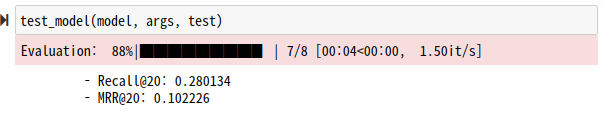

**6-2 모델 평가 결과2 : batch_size 증가, epochs 감소**

- batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

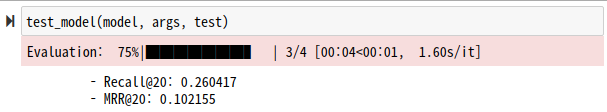

**6-3 모델 평가 결과3 : drop_rate 증가**
- batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20

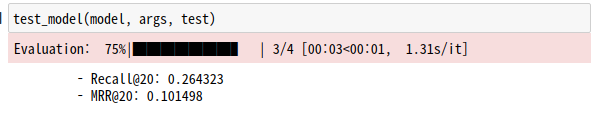

**6-4 모델 평가 결과4 : batch_size 감소**
- batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20

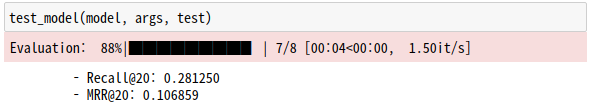

### ■ 정리 및 회고

NLP나 추천시스템 관련 노드가 나올 때마다 쉽지 않다. 하이퍼파라미터를 조금씩 바꿔가며 모델을 바꿔보았다. 조금씩 변화가 있긴한데, 성능이 많이 개선되었는지는 모르겠다. 이번 노드는 흐름이나 개념 자체를 이해하는데 상당이 어려웠다. 추가적으로 복습이 많이 필요하다..